In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as st
import similaritymeasures as sm

import pdb
import sys
sys.path.append('../')
import fig_format

In [6]:
data_str = 'v4'
data_path = f'data/patterns_{data_str}.json'

with open(data_path, 'r') as f:
    data = json.load(f)

In [3]:
def to_dfs(data):
    dfs = []
    for d in data:
        dfs.append(pd.DataFrame(d['data']))
    return dfs

In [8]:
data_c1 = to_dfs(filter(lambda x: x['config']['condition'] == "1", data))
data_c2 = to_dfs(filter(lambda x: x['config']['condition'] == "2", data))
# data_c3 = to_dfs(filter(lambda x: x['config']['condition'] == "3", data))


In [66]:
data_c1[0].query('set == "main" & step == 7').shape

(60, 15)

In [31]:
def calc_scores(data):
    scores = dict([(j, dict([(i, []) for i in range(1, 7)])) for j in range(1, 6)]) # outside is phase #, inside is pattern #
    for ix, participant in enumerate(data):
        td = participant.query('set == "main" & score > 0')
        
        for i in range(1,7): # 6 patterns
            tdi = td.query('step == @i')
            pattern = tdi.pattern.iloc[0]
            
            p1_score = tdi.query('phase == 1')['score']
            p2_score = tdi.query('phase == 2')['score']
            p3_score = tdi.query('phase == 3')['score']
            p4_score = tdi.query('phase == 4')['score']
            pb_score = td.query('phase == 4 & step == 7 & pattern == @pattern').score

            scores[1][i].append(np.mean(p1_score))
            scores[2][i].append(np.mean(p2_score))
            scores[3][i].append(np.mean(p3_score))
            scores[4][i].append(np.mean(p4_score))
            scores[5][i].append(np.mean(pb_score))
        
    return scores

In [32]:
scores_c1 = calc_scores(data_c1)
scores_c2 = calc_scores(data_c2)

In [33]:
scores_c2

{1: {1: [86.85000000000001,
   85.65999999999998,
   80.168,
   82.84,
   82.35600000000001],
  2: [81.004, 80.68, 86.868, 78.704, 86.47916666666667],
  3: [82.552, 82.304, 75.664, 68.564, 80.68799999999999],
  4: [84.436, 81.092, 87.804, 76.42399999999999, 79.872],
  5: [73.528, 76.74347826086957, 82.832, 71.172, 72.856],
  6: [83.95, 75.575, 77.164, 71.808, 79.524]},
 2: {1: [81.95, 83.02, 77.76, 78.84, 82.19000000000001],
  2: [83.88000000000001, 81.95, 88.65, 78.2, 86.36],
  3: [71.77000000000001, 71.59, 76.71, 69.36, 82.42999999999999],
  4: [86.79, 80.59, 81.18999999999998, 81.1, 83.93],
  5: [75.91999999999999, 74.19000000000003, 84.25999999999999, 77.41, 82.48],
  6: [89.27000000000001, 85.85, 83.53999999999999, 73.15, 79.39]},
 3: {1: [84.656, 84.90799999999999, 80.05199999999999, 82.4, 85.028],
  2: [83.78, 85.036, 83.288, 78.27600000000001, 89.31200000000001],
  3: [79.248, 84.00800000000001, 76.92, 80.268, 86.98],
  4: [85.928, 84.34166666666667, 82.72, 81.13600000000001, 8

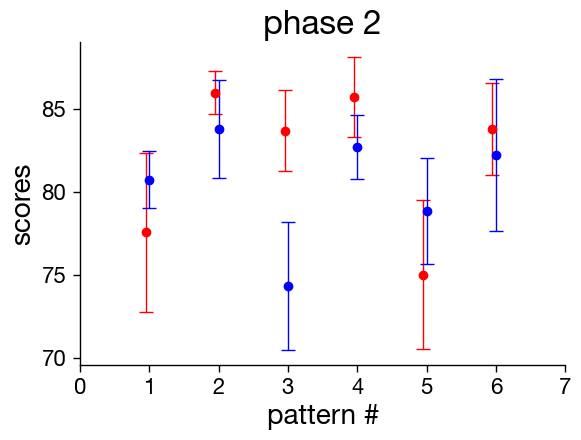

In [71]:
colors = cm.Set1
phase = 2
dx = scores_c1[phase]
dy = scores_c2[phase]
# dz = scores_c3[phase]
for i in range(1,7):
    i_mean_x = np.mean(dx[i])
    i_ints_x = st.norm.interval(0.9, loc=i_mean_x, scale=st.sem(dx[i]))
    i_mean_y = np.mean(dy[i])
    i_ints_y = st.norm.interval(0.9, loc=i_mean_y, scale=st.sem(dy[i]))
#     i_mean_z = np.mean(dz[i])
#     i_ints_z = st.norm.interval(0.9, loc=i_mean_z, scale=st.sem(dz[i]))
    plt.errorbar(i-.05, i_mean_x,
                 yerr=np.asarray([i_mean_x - i_ints_x[0], i_ints_x[1] - i_mean_x]).reshape(2,1),
                 color='red',
                 lw=1,
                 capsize=5,
                 marker='o',
                 label=1
                )
    plt.errorbar(i, i_mean_y,
                 yerr=np.asarray([i_mean_y - i_ints_y[0], i_ints_y[1] - i_mean_y]).reshape(2,1),
                 color='blue',
                 lw=1,
                 capsize=5,
                 marker='o',
                 label=2
                )
#     plt.errorbar(i+.05, i_mean_z,
#                  yerr=np.asarray([i_mean_z - i_ints_z[0], i_ints_z[1] - i_mean_z]).reshape(2,1),
#                  color='green',
#                  lw=1,
#                  capsize=5,
#                  marker='o',
#                  label=3
#                 )

plt.xlim([0, 7])
plt.title(f'phase {phase}')
plt.xlabel('pattern #')
plt.ylabel('scores')
fig_format.hide_frame(plt.gca())
plt.show()

In [44]:
def calc_distances(data, phase=4, samples=30):
    pdists = dict([(i, []) for i in range(1, 7)])
    for ix, participant in enumerate(data):
        td = participant.query('set == "main" & score > 0')
        
        for i in range(1,7): # 6 patterns
            tdi = td.query('step == @i')
            pattern = tdi.pattern.iloc[0]
            
            if phase <= 4: # not during bonus phase
                pdata = tdi.query('phase == @phase')['pointer_data'] # during testing phase
            else:
                pdata = td.query('phase == 4 & step == 7 & pattern == @pattern')['pointer_data'] # during bonus phase
            pdata_arrs = [] # array of positions, for use in calculating distances
            for p in pdata:
                pdata_arrs.append(np.stack([p['x'], p['y']]).T)
            dists = []
            for _ in range(samples):
                xi, xj = np.random.choice(len(pdata_arrs), 2, replace=False)
                dists.append(sm.frechet_dist(pdata_arrs[xi], pdata_arrs[xj]))
            pdists[i].append(np.mean(dists))
            
    return pdists
            
#         print(f'finished {ix+1}')

In [69]:
pdists_c1 = calc_distances(data_c1, phase=5)
pdists_c2 = calc_distances(data_c2, phase=5)

In [54]:
pdists_c1_p4 = calc_distances(data_c1, phase=4)
pdists_c2_p4 = calc_distances(data_c2, phase=4)

In [48]:
pdists_c1

{1: [0.13590855399289017,
  0.08378848052162303,
  0.07929490471798091,
  0.08719326364498076,
  0.09919528961729682],
 2: [0.1403342447197075,
  0.08341261159150633,
  0.08521751497663516,
  0.07708644159386134,
  0.19339498610140338],
 3: [0.1370016814483978,
  0.08712046208573386,
  0.09844884188676287,
  0.08505429240007518,
  0.12939286227519756],
 4: [0.15614627411081966,
  0.0991659757591963,
  0.08751752066868505,
  0.07185412273154869,
  0.10667389334047336],
 5: [0.15611663100180423,
  0.08540157310117089,
  0.12182048970707457,
  0.09544854780996496,
  0.11760489666886116],
 6: [0.1928945756502887,
  0.08763191735417784,
  0.1378344000135484,
  0.12729084088661463,
  0.18809851556864238]}

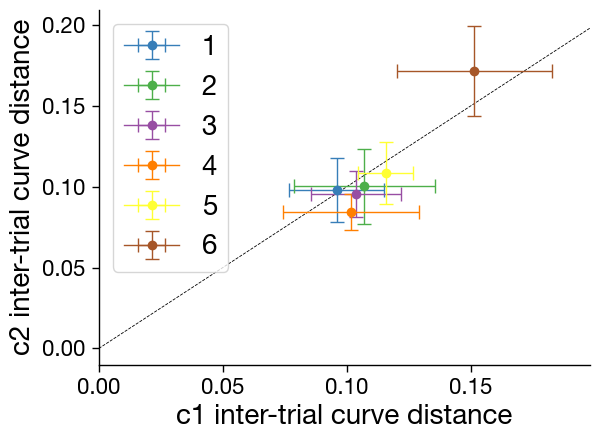

In [70]:
colors = cm.Set1
plt.plot(np.arange(100)/500, np.arange(100)/500, ls='--', c='black', lw=.6)

dx = pdists_c1
dy = pdists_c2
for i in range(1,7):
    i_mean_x = np.mean(dx[i])
    i_ints_x = st.norm.interval(0.9, loc=i_mean_x, scale=st.sem(dx[i]))
    i_mean_y = np.mean(dy[i])
    i_ints_y = st.norm.interval(0.9, loc=i_mean_y, scale=st.sem(dy[i]))
    plt.errorbar(i_mean_x, i_mean_y,
                 xerr=np.asarray([i_mean_x - i_ints_x[0], i_ints_x[1] - i_mean_x]).reshape(2,1),
                 yerr=np.asarray([i_mean_y - i_ints_y[0], i_ints_y[1] - i_mean_y]).reshape(2,1),
                 color=colors(i),
                 lw=1,
                 capsize=5,
                 marker='o',
                 label=i
                )

# plt.xlim([0,400])
# plt.ylim([0,400])
plt.xlabel('c1 inter-trial curve distance')
plt.ylabel('c2 inter-trial curve distance')
plt.legend()
fig_format.hide_frame(plt.gca())
plt.show()